# Information:
This NoteBook is here to have a clean version of what we did in the other NoteBook, it'll be the final one used, which should be clean, pretty and understable.

In [33]:
%matplotlib inline
import getters as hdf5_getters
import sqlite3 as sq
import os
import pandas as pd
import glob
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LogisticRegression

In [2]:
local_path = 'C:/Users/M4X/Documents/Uni/EPFL/ADA/ADA/project/data'

In [3]:
def get_all_interesting_data(basedir,ext='.h5') :
    datas = []
    iteration = 0
    for root, dirs, files in os.walk(basedir):
        files = glob.glob(os.path.join(root,'*'+ext))
        for f in files:
            oneSongData = []
            h5 = hdf5_getters.open_h5_file_read(f)
            oneSongData.append( hdf5_getters.get_artist_id(h5))
            oneSongData.append(hdf5_getters.get_artist_name(h5))
            oneSongData.append(hdf5_getters.get_year(h5))
            oneSongData.append(hdf5_getters.get_danceability(h5)) #always zero
            oneSongData.append(hdf5_getters.get_duration(h5))
            oneSongData.append(hdf5_getters.get_song_hotttnesss(h5))
            oneSongData.append(hdf5_getters.get_title)
            oneSongData.append(hdf5_getters.get_tempo(h5))
            oneSongData.append(hdf5_getters.get_time_signature(h5))
            oneSongData.append(hdf5_getters.get_time_signature_confidence(h5))
            oneSongData.append(hdf5_getters.get_artist_mbtags(h5))
            oneSongData.append(hdf5_getters.get_artist_terms(h5))
            oneSongData.append(hdf5_getters.get_artist_location(h5))
            oneSongData.append(hdf5_getters.get_artist_latitude(h5))
            oneSongData.append(hdf5_getters.get_artist_longitude(h5))
            h5.close()
            iteration+=1
            if(iteration%1000== 0):
                print(iteration)
            datas.append(oneSongData)
    return datas

In [4]:
datas = get_all_interesting_data(local_path)

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000


In [5]:
df = pd.DataFrame(datas,columns=['ArtistID','ArtistName','SongYear','SongDanceability','Duration','SongHotness','SongTitle','SongTempo','SongTimeSignature','SongTimeSignatureConfidence','ArtistMbtags','ArtistTerms','ArtistLocation','ArtistLatitude','ArtistLongitude'])

Since we want to analyze music evolution over time, we cannot use Songs without specified year.

In [6]:
df = df[df['SongYear']>0]

In [7]:
df.columns

Index(['ArtistID', 'ArtistName', 'SongYear', 'SongDanceability', 'Duration',
       'SongHotness', 'SongTitle', 'SongTempo', 'SongTimeSignature',
       'SongTimeSignatureConfidence', 'ArtistMbtags', 'ArtistTerms',
       'ArtistLocation', 'ArtistLatitude', 'ArtistLongitude'],
      dtype='object')

In [8]:
df.isnull().sum()

ArtistID                          0
ArtistName                        0
SongYear                          0
SongDanceability                  0
Duration                          0
SongHotness                    1616
SongTitle                         0
SongTempo                         0
SongTimeSignature                 0
SongTimeSignatureConfidence       0
ArtistMbtags                      0
ArtistTerms                       0
ArtistLocation                    0
ArtistLatitude                 2855
ArtistLongitude                2855
dtype: int64

TODO

In [9]:
df.describe()

,SongYear,SongDanceability,Duration,SongHotness,SongTempo,SongTimeSignature,SongTimeSignatureConfidence,ArtistLatitude,ArtistLongitude
count,4680.000000,4680.0,4680.000000,3064.000000,4680.000000,4680.000000,4680.000000,1825.000000,1825.000000
mean,1997.232051,0.0,238.781146,0.444377,125.163716,3.586111,0.510216,37.501760,-61.772744
std,11.686691,0.0,101.345438,0.222470,35.272251,1.240247,0.375063,16.273911,51.525675
min,1926.000000,0.0,1.044440,0.000000,0.000000,0.000000,0.000000,-41.280540,-155.434140
25%,1993.000000,0.0,181.152200,0.313562,98.698500,3.000000,0.089000,34.053490,-93.264930
50%,2001.000000,0.0,227.382400,0.473347,122.226500,4.000000,0.553000,40.102160,-79.385330
75%,2006.000000,0.0,278.406080,0.604554,146.572000,4.000000,0.868000,44.979030,-3.996670
max,2010.000000,0.0,1598.197100,1.000000,258.677000,7.000000,1.000000,69.651020,174.767140


|         |  ArtistID  | ArtistName |  SongYear  | SongDanceability |  Duration  | SongHotness | SongTitle |  SongTempo | SongTimeSignature | SongTimeSignatureConfidence | ArtistMbtags | ArtistTerms | ArtistLocation | ArtistLatitude | ArtistLongitude |
|:-------:|:----------:|------------|:----------:|:----------------:|:----------:|:-----------:|:---------:|:----------:|:-----------------:|:---------------------------:|:------------:|:-----------:|:--------------:|:--------------:|:---------------:|
|  format |     int    |   string   |     int    |       float      |    float   |    float    |   string  |    float   |                   |                             |    string    |    string   |     string     |      float     |      float      |
|   type  | categorial | categorial | continious |    continious    | continious |  continious |     -     | continious |      Ordinal      |          continious         |              |             |                |   continious   |    continious   |
| comment |            |            |            |                  |            |             |           |            |                   |                             |              |             |                |                |                 |
|         |            |            |            |                  |            |             |           |            |                   |                             |              |             |                |                |                 |

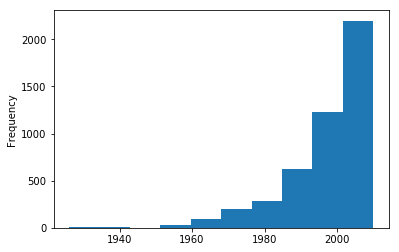

In [10]:
df.SongYear.plot(kind='hist')

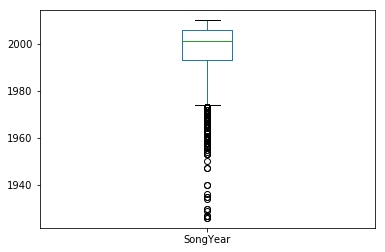

In [11]:
df.SongYear.plot.box()

The distribution of the year feature is negatively skewed.  
The available years span from 1926 to 2010.  
It makes sense to normalize the feature with scaling.

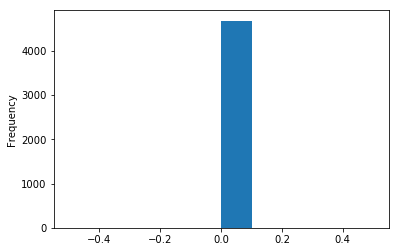

In [12]:
df.SongDanceability.plot(kind='hist')

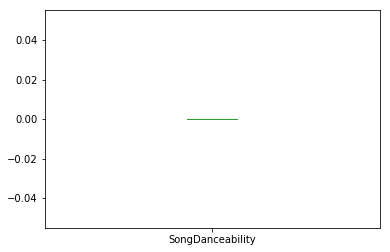

In [13]:
df.SongDanceability.plot.box()

In [14]:
print(df[df['SongDanceability'] == 0].shape[0])

4680


TODO Description: Subset only 0

(35, 15)
(73, 15)


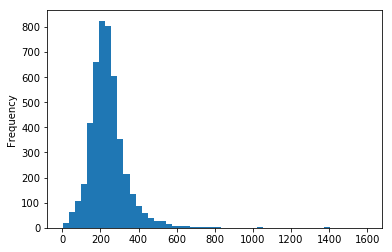

In [15]:
df.Duration.plot(kind='hist',bins=50)
print(df[df['Duration']>600].shape)
print(df[df['Duration']<60].shape)

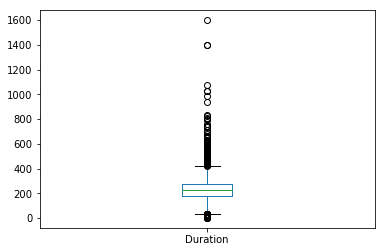

In [16]:
df.Duration.plot.box()

TODO Duration: Remove tails

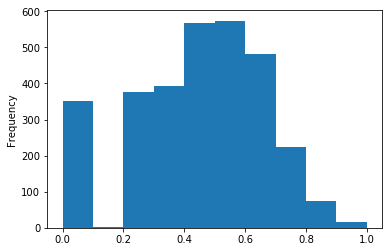

In [17]:
df.SongHotness.plot(kind='hist')

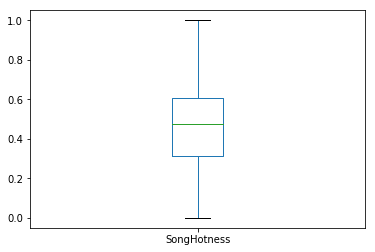

In [18]:
df.SongHotness.plot.box()

TODO Hotness: Distribution  
When analysing hotness remove songs with hotness of zero.

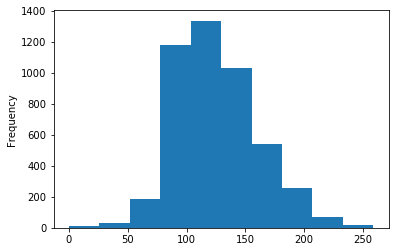

In [19]:
df.SongTempo.plot(kind='hist')

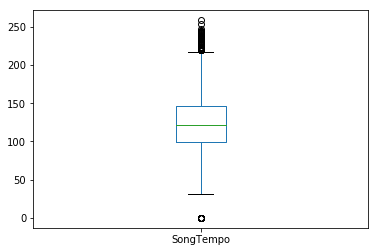

In [20]:
df.SongTempo.plot.box()

TODO Tempo: Distribution, remove tails?

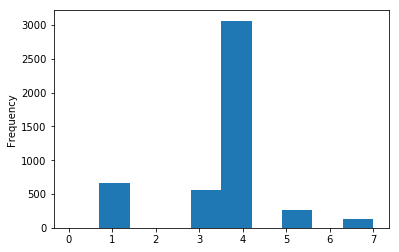

In [21]:
df.SongTimeSignature.plot(kind='hist')

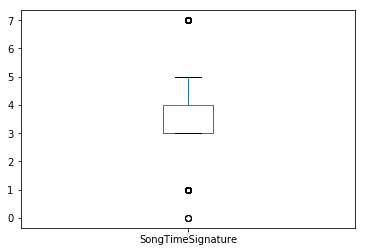

In [22]:
df.SongTimeSignature.plot.box()

TODO: Distribution

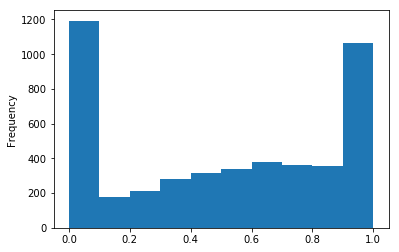

In [23]:
df.SongTimeSignatureConfidence.plot(kind='hist')

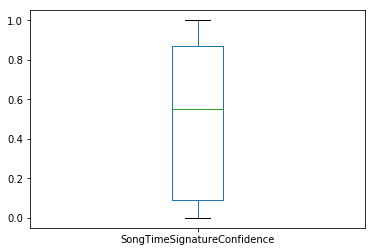

In [24]:
df.SongTimeSignatureConfidence.plot.box()

TODO Distribution  
When analysing TimeSignature remove songs with low confidence

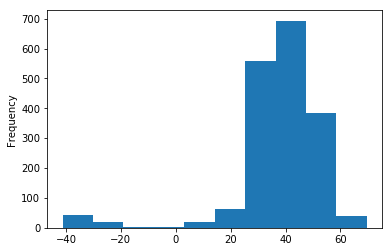

In [25]:
df.ArtistLatitude.plot(kind='hist')

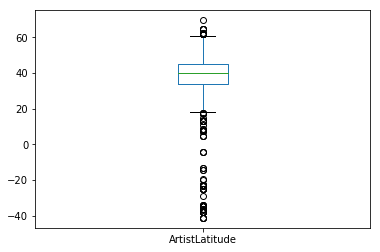

In [26]:
df.ArtistLatitude.plot.box()

TODO

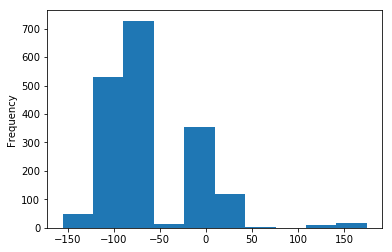

In [27]:
df.ArtistLongitude.plot(kind='hist')

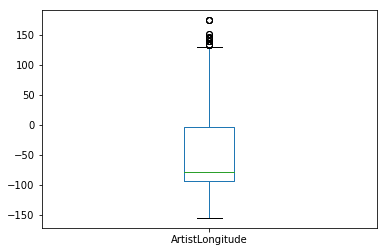

In [28]:
df.ArtistLongitude.plot.box()

TODO

In [29]:
df.corr()

,SongYear,SongDanceability,Duration,SongHotness,SongTempo,SongTimeSignature,SongTimeSignatureConfidence,ArtistLatitude,ArtistLongitude
SongYear,1.000000,NaN,0.059714,0.072216,0.020238,0.122848,0.116367,-0.046133,0.017640
SongDanceability,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Duration,0.059714,NaN,1.000000,0.007171,-0.031175,0.103162,0.118071,0.082933,0.065677
SongHotness,0.072216,NaN,0.007171,1.000000,0.068544,0.036205,0.040898,0.059111,-0.058235
SongTempo,0.020238,NaN,-0.031175,0.068544,1.000000,0.054625,-0.146500,-0.004998,-0.017976
SongTimeSignature,0.122848,NaN,0.103162,0.036205,0.054625,1.000000,0.324779,0.027432,0.012819
SongTimeSignatureConfidence,0.116367,NaN,0.118071,0.040898,-0.146500,0.324779,1.000000,-0.000546,0.042804
ArtistLatitude,-0.046133,NaN,0.082933,0.059111,-0.004998,0.027432,-0.000546,1.000000,0.028890
ArtistLongitude,0.017640,NaN,0.065677,-0.058235,-0.017976,0.012819,0.042804,0.028890,1.000000


In [ ]:
plt.scatter()

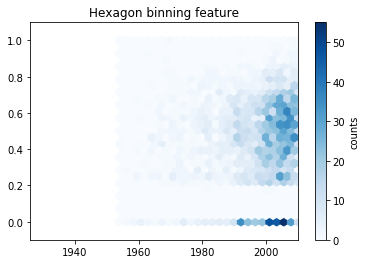

In [35]:
x = df.SongYear
y = df.SongHotness
xmin = x.min()
xmax = x.max()
ymin = y.min()
ymax = y.max()

fig, ax = plt.subplots()
hb = ax.hexbin(x, y, gridsize=25, cmap='Blues')
ax.axis([xmin, xmax, ymin - 0.1, ymax + 0.1])
ax.set_title("Hexagon binning Year, Hotness")
cb = fig.colorbar(hb, ax=ax)
cb.set_label('counts')

plt.show()

TODO other plots, improbe coloring

TODO Feature normalization for ML?

TODO Discretization, additional feature calculation, other feature engineering 

TODO Genre Mapping + stats for different genres